# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os
import datetime
import seaborn as sns

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
combined = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))

In [4]:
combined

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Metadata

In [5]:
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [173]:
#metadata[(metadata.lon< -43.2) & (metadata.lat< 22.5) & (metadata.state=='RJ')] #429

### Single rain gauge over time

In [7]:
sns.set_style('whitegrid')
def plotGaugeTimeseries(ind):
    fig, ax = plt.subplots(figsize=(16,8))
    plt.plot(combined.time, combined.mlp_posterior_mean[:, ind], label='mlp')
    plt.plot(combined.time, combined.xception_posterior_mean[:, ind], label='cnn')
    plt.plot(combined.time, combined.HE_precip[:, ind], label='HE')
    plt.plot(combined.time, combined.HE_precip_corr[:, ind], label='corrected HE')
    plt.plot(combined.time, combined.gauge_precip[:, ind], label='gauge')

    ax.set_ylabel('rain (mm)')
    ax.set_xlabel('datetime (hour)')
    ax.legend()

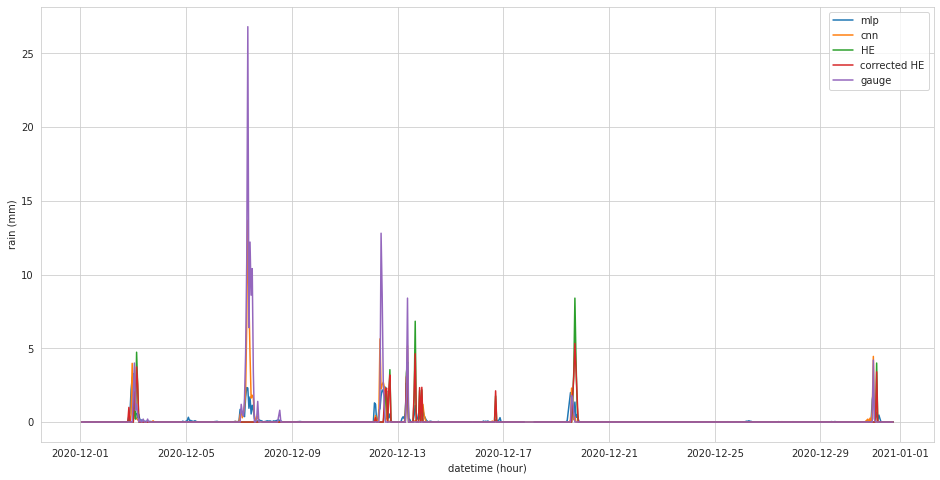

In [9]:
plotGaugeTimeseries(510)

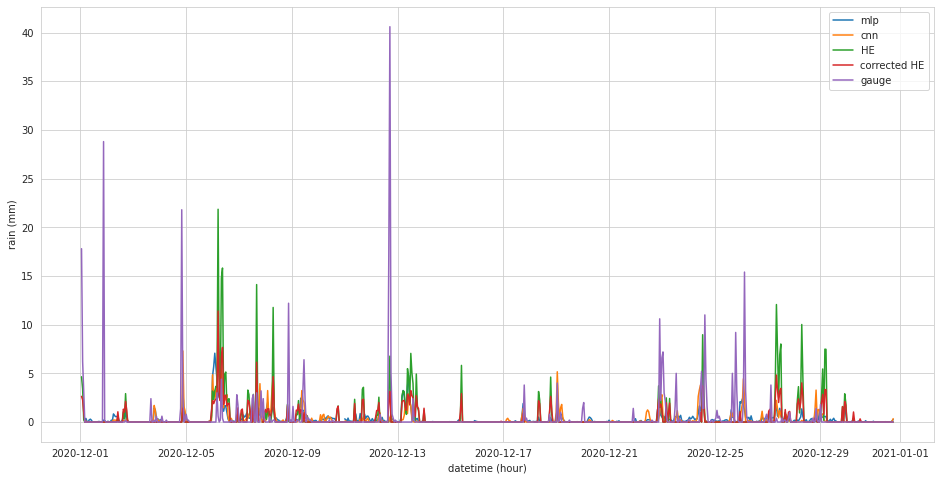

In [10]:
plotGaugeTimeseries(180)

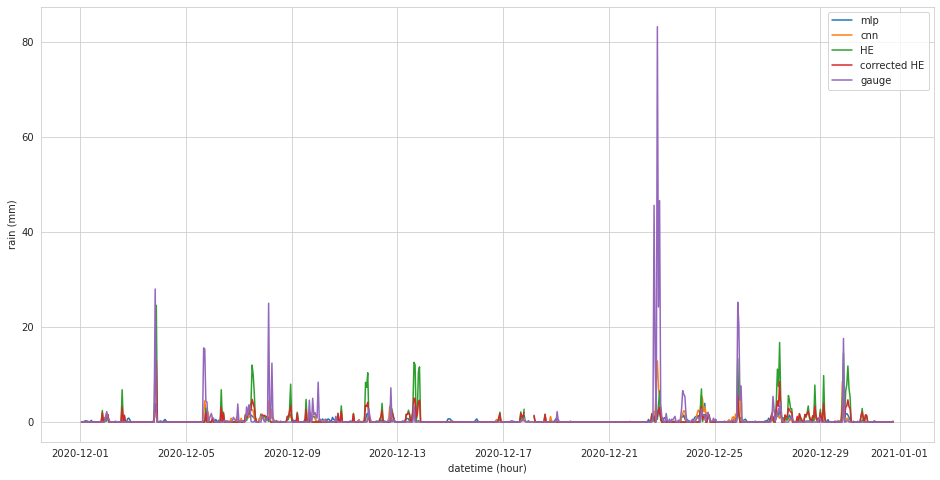

In [8]:
plotGaugeTimeseries(429) # Xerém

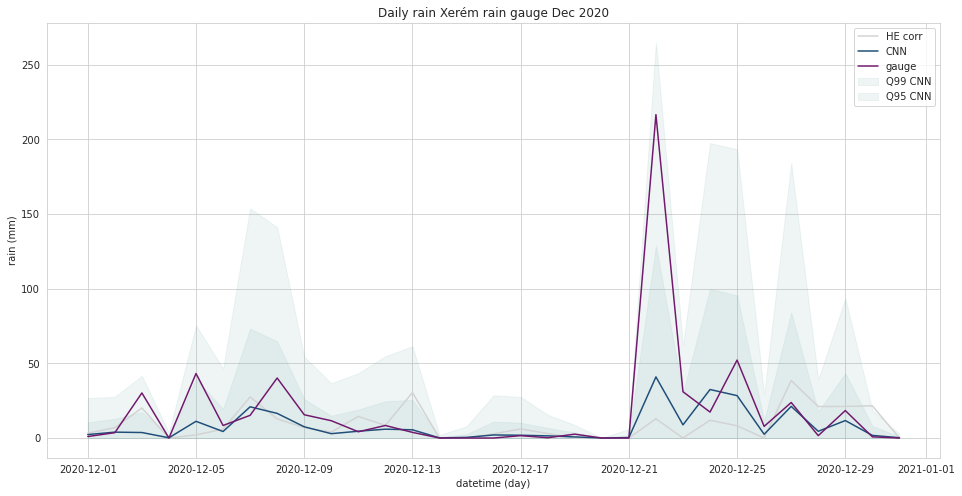

In [172]:
sns.set_style('whitegrid')
ind = 429
daym = combined.copy()
daym = daym.resample(time='D').sum()
fig, ax = plt.subplots(figsize=(16,8))
#plt.plot(daym.time, daym.mlp_posterior_mean[:, ind], label='mlp')
#ax.plot(daym.time, daym.HE_precip[:, ind], label='HE', color='#e6e6e6')
ax.fill_between(daym.time, daym['xception_Q0.99'][:, ind], alpha=0.1, label='Q99 CNN', color='#64a6a1')
ax.fill_between(daym.time, daym['xception_Q0.95'][:, ind], alpha=0.1, label='Q95 CNN', color='#64a6a1')

ax.plot(daym.time, daym.HE_precip_corr[:, ind], label='HE corr', color='lightgrey')
ax.plot(daym.time, daym.xception_posterior_mean[:, ind], label='CNN', color='#1f4e79')
ax.plot(daym.time, daym.gauge_precip[:, ind], label='gauge', color='#72196d')

ax.set_ylabel('rain (mm)')
ax.set_xlabel('datetime (day)')
ax.set_title('Daily rain Xerém rain gauge Dec 2020')
ax.legend()

### Scalar metrics

Bias

In [13]:
# HE
np.nanmean(combined.gauge_precip-combined.HE_precip)

-0.10395083635324988

In [14]:
# HE corr
np.nanmean(combined.gauge_precip-combined.HE_precip_corr)

0.006716587598407625

In [16]:
# MLP
np.nanmean(combined.gauge_precip-combined.mlp_posterior_mean)

0.020730019446901587

In [15]:
# CNN
np.nanmean(combined.gauge_precip-combined.xception_posterior_mean)

-0.004699792821834451

MAE

In [39]:
# HE
np.nanmean(np.abs(np.subtract(combined.gauge_precip.values, combined.HE_precip.values)))

0.39366737478503555

In [40]:
# HE corr
np.nanmean(np.abs(np.subtract(combined.gauge_precip.values, combined.HE_precip_corr.values)))

0.300251265975805

In [42]:
# MLP
np.nanmean(np.abs(np.subtract(combined.gauge_precip.values, combined.mlp_posterior_mean.values)))

0.26556459415067035

In [41]:
# CNN
np.nanmean(np.abs(np.subtract(combined.gauge_precip.values, combined.xception_posterior_mean.values)))

0.23248597217680866

MSE

In [17]:
# HE
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.HE_precip.values)))

3.940874754925588

In [18]:
# HE corr
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.HE_precip_corr.values)))

2.438601627897914

In [20]:
# MLP
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.mlp_posterior_mean.values)))

2.0412893711302513

In [19]:
# CNN
np.nanmean(np.square(np.subtract(combined.gauge_precip.values, combined.xception_posterior_mean.values)))

1.7017950619618283

### Histograms 

20


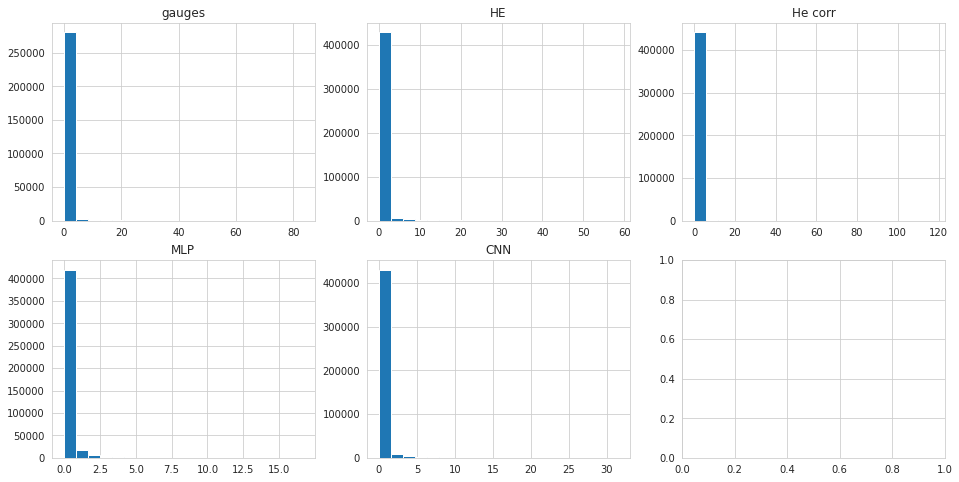

In [174]:
bins = 20#None#np.linspace(0, 4, num=20)
print(bins)

fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
ax[0,0].hist(combined.gauge_precip.values.flatten(), bins=bins)
ax[0,0].set_title('gauges')

ax[0,1].hist(combined.HE_precip.values.flatten(), bins=bins)
ax[0,1].set_title('HE')

ax[0,2].hist(combined.HE_precip_corr.values.flatten(), bins=bins)
ax[0,2].set_title('He corr')

ax[1,0].hist(combined.mlp_posterior_mean.values.flatten(), bins=bins)
ax[1,0].set_title('MLP')

ax[1,1].hist(combined.xception_posterior_mean.values.flatten(), bins=bins)
ax[1,1].set_title('CNN')

plt.show()


### NaNs

In [26]:
np.isnan(combined.HE_precip.values).sum()

6090

In [27]:
np.isnan(combined.xception_posterior_mean.values).sum()

1759

In [28]:
np.isnan(combined.mlp_posterior_mean.values).sum()

1759

In [29]:
isnans = np.isnan(combined.gauge_precip.values).sum()
isnans

165555

In [30]:
alls = len(combined.gauge_precip.values.flatten())
alls

449442

In [31]:
isnans/alls

0.36835676238535786

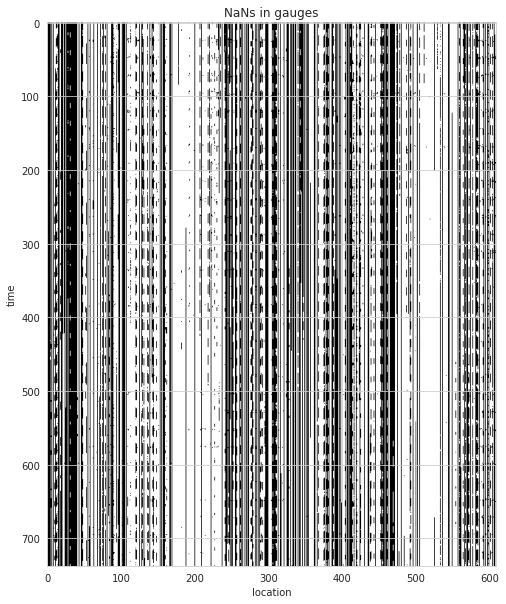

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined.gauge_precip.values
#print(data)
mask = np.zeros((data.shape[0], data.shape[1]))
mask[np.isnan(data)] = 1
#print(mask)
ax.imshow(mask, cmap='binary')
#fig.colorbar(m)
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in gauges')
plt.show()

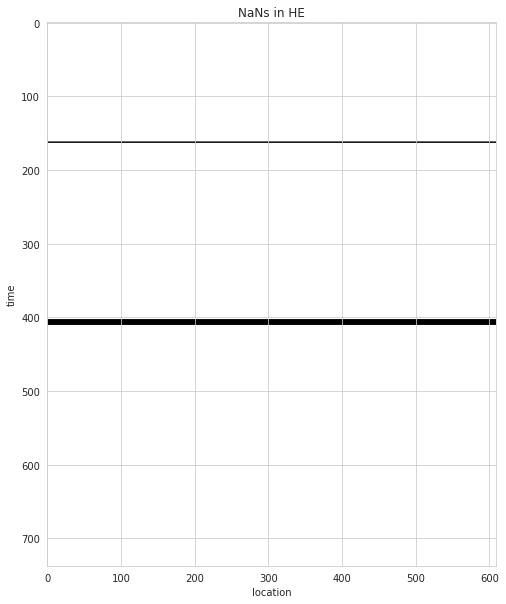

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined.HE_precip.values
#print(data)
mask = np.zeros((data.shape[0], data.shape[1]))
mask[np.isnan(data)] = 1
#print(mask)
ax.imshow(mask, cmap='binary')
#fig.colorbar(m)
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in HE')
plt.show()

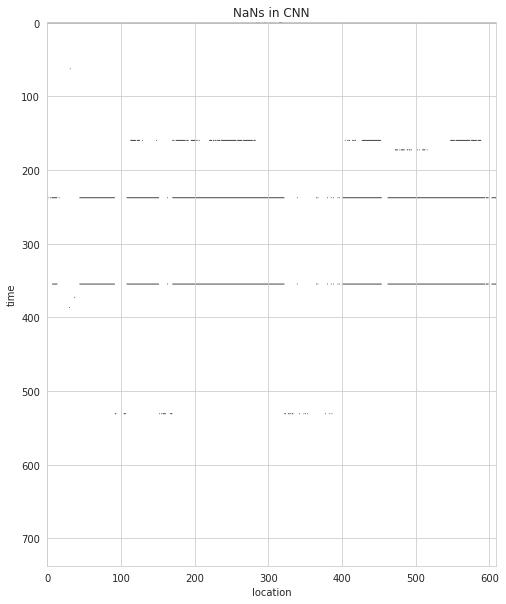

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined.xception_posterior_mean.values
#print(data)
mask = np.zeros((data.shape[0], data.shape[1]))
mask[np.isnan(data)] = 1
#print(mask)
ax.imshow(mask, cmap='binary')
#fig.colorbar(m)
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in CNN')
plt.show()

### By region

In [123]:
reg = ['N', 'SE', 'CW', 'S', 'NE'] #np.unique(metadata.region)
print(reg)
mse_by_region = np.zeros((len(reg),4))

['N', 'SE', 'CW', 'S', 'NE']


In [134]:
for i in range(len(reg)):
    locs = list(metadata.index[metadata.region == reg[i]])
    print(len(locs))
    selection = combined.copy().isel(location=locs)
    mse_by_region[i,0] = np.nanmean(np.square(np.subtract(selection.gauge_precip.values, selection.HE_precip.values)))
    mse_by_region[i,1] = np.nanmean(np.square(np.subtract(selection.gauge_precip.values, selection.HE_precip_corr.values)))
    mse_by_region[i,2] = np.nanmean(np.square(np.subtract(selection.gauge_precip.values, selection.mlp_posterior_mean.values)))
    mse_by_region[i,3] = np.nanmean(np.square(np.subtract(selection.gauge_precip.values, selection.xception_posterior_mean.values)))

100
149
115
95
150


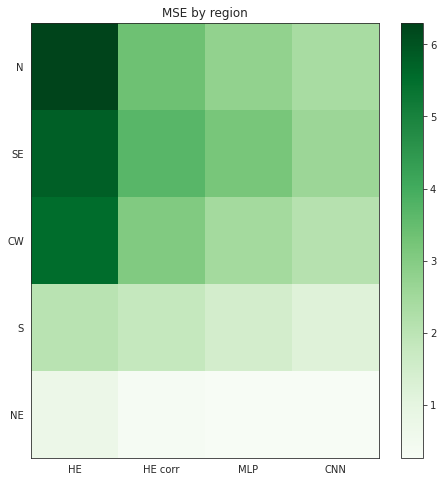

In [135]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(mse_by_region, cmap='Greens')
ax.set_yticks(list(range(len(reg))))
ax.set_yticklabels(reg)
mods = ['HE', 'HE corr', 'MLP', 'CNN']
ax.set_xticks(list(range(len(mods))))
ax.set_xticklabels(mods)
ax.set_title('MSE by region')
fig.colorbar(m)
plt.show()